In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score
)

2026-02-24 17:41:08.898582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-24 17:41:08.898789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-24 17:41:08.930115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-24 17:41:09.735369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [2]:
# convert data type
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.replace(',', '.')
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

In [3]:
# read data base

ds = pd.read_csv('base_maior.csv')
for col in ds.columns[:-1]:
    ds[col] = ds[col].apply(convert_to_numeric)

colunas_num = ds.select_dtypes(include=[np.number]).columns
ds[colunas_num] = ds[colunas_num].pct_change() * 100 
ds = ds.dropna().reset_index(drop=True)

/tmp/ipykernel_34300/3036413839.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ds[colunas_num] = ds[colunas_num].pct_change() * 100


In [4]:
# remove extreme outliers

ds[colunas_num] = ds[colunas_num].clip(-100, 100)

x = ds.iloc[:, :-1]. values
y = ds.iloc[:, -1].values

if y.dtype == 'O' or not np.issubdtype(y.dtype, np.integer):
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    classes = list(encoder.classes_)

    if "Sim" in classes and classes.index("Sim") !=1:
        y = np.where(y == 1,0,1)
        print("'Sim' = 1 e 'Não' = 0")
    else:
        print("Subiu ja é classe positiva")



Subiu ja é classe positiva


In [5]:
# normalization z-core

scaler = RobustScaler()
x = scaler.fit_transform(x)

In [6]:
# train and validation 

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)
print("data format:")
print("train:", x_train.shape, y_train.shape)
print("validation:", x_val.shape, y_val.shape)

print("class in train:", np.unique(y_train))
print("class in validation:", np.unique(y_val))

data format:
train: (5895, 20) (5895,)
validation: (1474, 20) (1474,)
class in train: [0 1]
class in validation: [0 1]


In [7]:
# throwing an invalid argument error (object) > convert to float

x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [10]:
# class weight 

classes = np.unique(y_train)
class_weight = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight))
print("class weight:", class_weight_dict)


class weight: {0.0: 0.8780160857908847, 1.0: 1.1613475177304964}


In [11]:
# DNN (Deep Neural Network) model 

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((x_train.shape[1],)),
    # 1 camada (+ neuronios)
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # 2 camada
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # 3 camada
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])

2026-02-24 17:45:19.037483: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # taxa de aprendizado menor
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=20,
    verbose=1,
    min_delta=0.001,
    cooldown=5,
    min_lr=1e-6
)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    min_delta=0.001,
    restore_best_weights=True
)

In [15]:
# train

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=200,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_on_plateau]
)

Epoch 1/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5025 - loss: 1.0481 - val_accuracy: 0.5543 - val_loss: 0.8169 - learning_rate: 1.0000e-04
Epoch 2/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.4992 - loss: 0.9412 - val_accuracy: 0.5543 - val_loss: 0.7869 - learning_rate: 1.0000e-04
Epoch 3/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.4986 - loss: 0.8968 - val_accuracy: 0.5563 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 4/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.5101 - loss: 0.8344 - val_accuracy: 0.5529 - val_loss: 0.7464 - learning_rate: 1.0000e-04
Epoch 5/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.4999 - loss: 0.8247 - val_accuracy: 0.5543 - val_loss: 0.7336 - learning_rate: 1.0000e-04
Epoch 6/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5070 - loss: 0.7955 - val_accuracy: 0.5563 - val_loss: 0.7210 - learning_rate: 1.0000e-04
Epoch 7/200
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/

In [ ]:
#model.save('dnn_model_1.h5') # if need save
#model.evaluate(x_val, y_val)


In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [17]:
epochs_range = range(len(acc))

Text(0.5, 1.0, 'Acurácia - Treino vs validação')

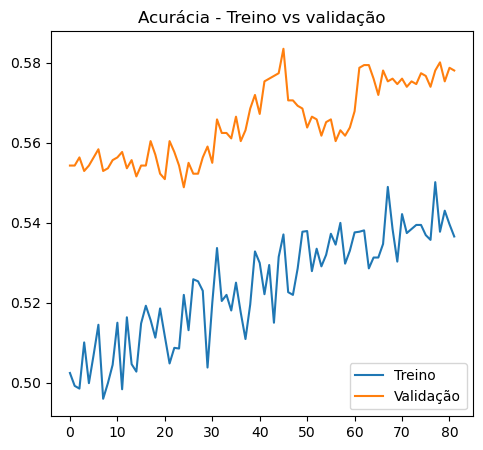

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia - Treino vs validação')


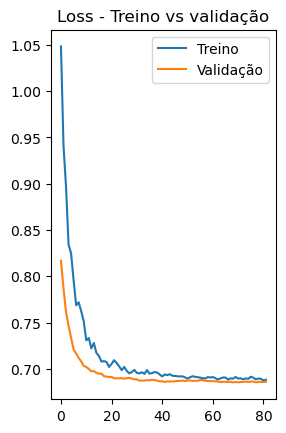

In [19]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Loss - Treino vs validação')
plt.show()

In [20]:
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [21]:
# evaçuation metrics 

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = np.mean(y_val == y_pred)
auc = roc_auc_score(y_val, y_pred_prob[:, 1])

In [ ]:
metrics_df = pd.accuracy({
    'metrics': ['accuracy', 'Precisão', 'Recall (Sensibilidade)', 'F1-Score', 'AUC'],
    'Valor': [accuracy, precision, recall, f1, auc]
})
print("\nmétricas")
print(metrics_df.to_string(index=False, float_format='{:,.4f}'.format))
